In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv("train.csv")
# print(df)
df.head(5)

# df.info()
df.isnull().sum()
data= df.drop(columns=['society','area_type','availability'])
data.head(5)

data.isnull().sum()


location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [11]:
#print(df['size'].value_counts())
data['size']= data['size'].fillna('2BHK')      # replacing the missing size with the most occurring size
data['location']=data['location'].fillna('Others')       # replacing location with others i.e. only 1


data['bath']=pd.to_numeric(data['bath'], errors='coerce')        # it will convert the string into numeric and also the error=corece is for those 
                                                            # who will not be able to convert will be replaced with NaN.
median_bath= data['bath'].median()
data['bath']=data['bath'].fillna(median_bath)
data.isnull().sum()



median_balcony= data['balcony'].median()
data['balcony']=data['balcony'].fillna(median_balcony)
data.isnull().sum()

#  Some entries in total_sqft may be in a range (like "1000-1200") or non-numeric. Handle them:

def convert_sqft(x):
    try:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft)

data['price_per_sqft'] = data['price'] * 100000 / data['total_sqft']


data['bhk'] = data['size'].str.extract(r'(\d+)').astype(float)       # we have extracted first numeric from size and put insert it to the bhk column with float dtype

data.drop('size',axis=1, inplace=True)
data.describe()





,total_sqft,bath,balcony,price,price_per_sqft,bhk
count,13274.000000,13320.000000,13320.000000,13320.000000,1.327400e+04,13320.000000
mean,1559.626694,2.688814,1.603378,112.565627,7.907501e+03,2.802778
std,1238.405258,1.338754,0.803067,148.971674,1.064296e+05,1.294496
min,1.000000,1.000000,0.000000,8.000000,2.678298e+02,1.000000
25%,1100.000000,2.000000,1.000000,50.000000,4.266865e+03,2.000000
50%,1276.000000,2.000000,2.000000,72.000000,5.434306e+03,3.000000
75%,1680.000000,3.000000,2.000000,120.000000,7.311746e+03,3.000000
max,52272.000000,40.000000,3.000000,3600.000000,1.200000e+07,43.000000


In [12]:
# trying to remove outliers

def remove_outlier_sqft(df):
    df_output = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m= np.mean(subdf.price_per_sqft)

        st= np.std(subdf.price_per_sqft)

        gen_df= subdf[(subdf.price_per_sqft > (m-st))&(subdf.price_per_sqft<=(m+st))]
        df_output= pd.concat([df_output,gen_df],ignore_index=True)
    return df_output
data= remove_outlier_sqft(data)

data.price_per_sqft.describe()


def bhk_outlier_remover(df):                                      
    exclude_indices= np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk]= {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std' : np.std(bhk_df.price_per_sqft),
                'count' : bhk_df.shape[0]
            }
        print(location, bhk_stats)
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']> 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft(stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

# data = bhk_outlier_remover(data)
data.describe()

,total_sqft,bath,balcony,price,price_per_sqft,bhk
count,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000,10122.000000
mean,1512.796849,2.528354,1.605118,98.365303,6035.483600,2.637325
std,920.363470,1.054130,0.786876,116.584455,7266.624510,0.979365
min,11.000000,1.000000,0.000000,8.000000,1150.172117,1.000000
25%,1100.000000,2.000000,1.000000,49.132500,4272.727273,2.000000
50%,1280.000000,2.000000,2.000000,68.000000,5260.367064,3.000000
75%,1650.000000,3.000000,2.000000,104.750000,6644.405653,3.000000
max,30400.000000,14.000000,3.000000,2912.000000,672727.272727,10.000000


In [13]:

# Now we are converting categorical values into numerical values like location

data['location']=data['location'].apply(lambda x : x.strip())   # this is used to remove whitespace
location_count= data['location'].value_counts()
print(location_count)

# location less than 10

location_count_less_10= location_count[location_count<=10]
location_count_less_10



data['location'] = data['location'].apply(
    lambda x: 'other' if x in location_count_less_10 else x
)

data['location'].value_counts()


# CLEAN DATA
data.drop(columns=['price_per_sqft'],inplace=True,axis=1)

#data['total_sqft'].fillna(data['total_sqft'].median(), inplace=True)



# model train

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

X=data.drop(columns=['price'])
y=data['price']

X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=0)
X_train.shape
X_test.shape


# Applying linear regression 

column_trans= make_column_transformer((OneHotEncoder(sparse_output=False),['location']),remainder='passthrough')
scaler= StandardScaler()
lr= LinearRegression()
pipe= make_pipeline(column_trans,scaler,lr)


pipe.fit(X_train,y_train)


y_pred_lr= pipe.predict(X_test)
r2_score(y_test,y_pred_lr)

location
Whitefield              535
Sarjapur  Road          398
Electronic City         286
Kanakpura Road          200
Yelahanka               185
                       ... 
Bhagyalakshmi Avenue      1
Whitefield,               1
1st Block BEL Layout      1
manyata park              1
south                     1
Name: count, Length: 802, dtype: int64


0.7448505450114493

In [14]:
# Apply Ridge
ridge=Ridge()
pipe= make_pipeline(column_trans,scaler, ridge)
pipe.fit(X_train,y_train)


y_pred_ridge= pipe.predict(X_test)
r2_score(y_test,y_pred_ridge)

0.7448375003466181

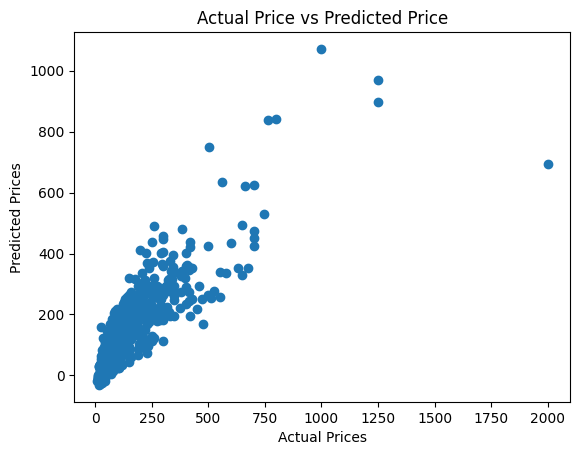

In [12]:
# Visualizing the actual price and predicted price
plt.scatter(y_test,y_pred_lr)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Price vs Predicted Price")
plt.show()

In [19]:
#print(df['location'].value_counts())
print(df['bath'].dtype)
print(df['balcony'].value_counts())

float64
balcony
2.0    5113
1.0    4897
3.0    1672
0.0    1029
Name: count, dtype: int64


In [20]:
print(df['total_sqft'].dtype)
data['total_sqft'].unique()[:100]

print(data['location'].value_counts())

object
location
other                   402
Whitefield              268
Sarjapur  Road          191
Uttarahalli              90
Kanakpura Road           82
                       ... 
Laggere                   2
Narayanapura              2
Thyagaraja Nagar          2
Vishveshwarya Layout      2
Vishwapriya Layout        2
Name: count, Length: 240, dtype: int64


In [ ]:
#X.isnull().sum()
# Fill missing total_sqft values


data['total_sqft'].isnull().sum()

# print(X)
# X=data.drop(columns=['price'])

C:\Users\shubh\AppData\Local\Temp\ipykernel_6000\3686219592.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_sqft'].fillna(data['total_sqft'].median(), inplace=True)


np.int64(0)

In [19]:
X.isnull().sum()

location           0
total_sqft         0
bath               0
balcony            0
price_per_sqft    46
bhk                0
dtype: int64